In [9]:
#合并Twitter的userinfo,并去除无用数据
import csv
import os
import pandas as pd
import pickle
out = open('data/twitter/userinfo_all.txt','w+',encoding='utf-8')
for i in os.listdir('data/twitter'):
    if not os.path.isdir('data/twitter/'+i) or 'followings' in i:continue
    for d in os.listdir('data/twitter/'+i):
        dd = f'data/twitter/{i}/{d}/'
        with open(f'{dd}/userinfo.txt',encoding='UTF-8-sig') as f:
            q=f.readlines()
            for j in range(len(q)-1):
                try:
                    x=q[j+1]
                    x=x[:x.find('##')]
                    x=int(x)
                    print(q[j][:-1],file=out)
                except:
                    print(q[j][:-1],file=out,end='')
            print(q[-1].strip(),file=out)
out.close()
#排序
out = open('data/twitter/userinfo_all.txt','r',encoding='utf-8')
d=[i.strip().split('##') for i in out.readlines()]
d=sorted(d,key=lambda x:int(x[0]))
with open('data/twitter/userinfo_all_final.pickle','wb') as f:
    pickle.dump(d,f)
out.close()

In [10]:
#处理Twitter的关注信息
#只保存url否则文件太大
import os
for i in os.listdir('data/twitter'):
    if not os.path.isdir('data/twitter/'+i) or '-' not in i:continue
    for d in os.listdir('data/twitter/'+i):
        for dd in os.listdir(f'data/twitter/{i}/{d}/followings'):
            ddd = f'data/twitter/{i}/{d}/followings/{dd}'
            with open(ddd,encoding='UTF-8-sig') as f:
                # print(f.name)
                out = open(f'data/twitter/followings/{f.name[f.name.rfind("/")+1:]}','w',encoding='utf-8')
                q=f.readlines()
                #第一行不要了，关注人的描述也不要了
                for j in range(1,len(q)-1):
                    if q[j+1].count('##') == 2:
                        # 正常一行
                        print(q[j][:-1],file=out)
                    else:
                        print(q[j][:-1],file=out,end='')
                print(q[-1].strip(),file=out)
                out.close()

#只保存url否则文件太大
#直接获得所有的字典
base = 'followings_small'
for i in os.listdir('data/twitter/followings'):
    with open(f'data/twitter/followings/{i}',encoding='UTF-8') as f:
        out = open(f'data/twitter/{base}/{i}','w',encoding='utf-8')
        out.writelines([l[l.find('##')+2:l.rfind('##')]+'\n' if l.find('##') !=-1
                        else l for l in f.readlines()])
        out.close()

In [8]:
#获得URL2id，属性关系和关注关系、字符集合
import os
import pandas as pd
import pickle
base = 'data/twitter/followings_small/'
col=['用户ID','URL','推特里的userid','昵称','个人describe','开通推特时间','location','tweet总数',
                                  'following总数','follower总数','favorites总数']
userinfo = pd.DataFrame(pickle.load(open('data/twitter/userinfo_all_final.pickle','rb')),columns=col)
print(userinfo['用户ID'][0])
URL2id = {userinfo.loc[i]['URL']:userinfo.loc[i]['用户ID'] for i in range(userinfo.shape[0])}
id2URL = {userinfo.loc[i]['用户ID']:userinfo.loc[i]['URL'] for i in range(userinfo.shape[0])}
pickle.dump(URL2id,open('data/twitter/URL2id.pickle','wb'))
pickle.dump(id2URL,open('data/twitter/id2URL.pickle','wb'))
#字符集合
char_set=set()
for i in range(userinfo.shape[0]):
    for j in userinfo.loc[i][['昵称','个人describe','开通推特时间','location','tweet总数',
                                  'following总数','follower总数','favorites总数']]:
        char_set|=set(j)
with open('data/twitter/char_set.txt','w',encoding='utf-8') as f:
    f.writelines([i+'\n' for i in char_set])
pickle.dump(char_set,open('data/twitter/char_set.pickle','wb'))
#关系三元组,都为关注
base = 'followings_small'
data=[]
t=0
#17009
num={} #关注人数统计
for i in os.listdir('data/twitter/followings_small'):
    with open(f'data/twitter/followings_small/{i}',encoding='UTF-8') as f:
        if i[:i.find('_')] not in id2URL:
            print(f'id {i[:i.find("_")]} not found')
            continue
        t+=1
        idx=i[:i.find('_')]
        s=0
        num[idx]=0
        for j in f:
            key='https://twitter.com'+j.strip()
            if key not in URL2id:
                # print(f'key {key} not in URL2ID')
                s+=1
                continue
            num[idx]+=1
            data.append([idx,URL2id[key]])
print(f'共 {s} 条无用记录')
data.sort(key=lambda x:int(x[0]))
with open('data/twitter/rel.txt','w',encoding='utf-8') as f:
    f.writelines([' '.join(i) for i in data])
pickle.dump(data,open('data/twitter/rel.pickle','wb'))

#属性三元组（h，r，属性值）
attr_rel=[]
attrs=['昵称','个人describe','开通推特时间','location','tweet总数',
                                  'following总数','follower总数','favorites总数']

encoding={i[1]:i[0] for i in enumerate(attrs)}
for i in range(userinfo.shape[0]):
    idx=userinfo.loc[i]['用户ID']
    for j in attrs:
        attr_rel.append([idx,encoding[j],userinfo.loc[i][j]])
pickle.dump(attr_rel,open('data/twitter/attr_rel.pickle','wb'))

4
id 21642 not found
共 488 条无用记录


1
20 21


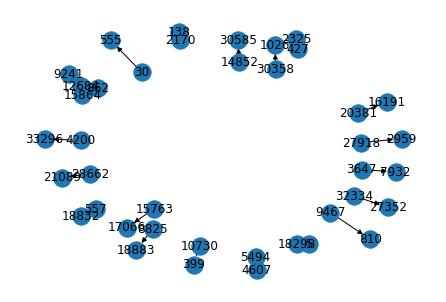

In [2]:
%matplotlib inline
#画图
import networkx as nx
import matplotlib.pyplot as plt
import random
g= nx.DiGraph()
tt=1
with open('data/twitter/rel.txt','r',encoding='utf-8') as f:
    cc=f.readlines()
    for i in random.choices(cc,k=20):
        tt+=1
        d=i.strip().split(' ')
        g.add_edge(d[0],d[1])
print(1)
print(g.size(),tt)
nx.draw(g,with_labels=True)
plt.show()
